In [ ]:
from __future__ import print_function
import sdm as sdmlib
from collections import defaultdict
import random
import string
import time
from math import ceil
from IPython.display import clear_output
import matplotlib.pyplot as plt

#%load_ext line_profiler

empty = ' '
flip_table = string.maketrans('OX', 'XO')

In [ ]:
class Player(object):
    def __init__(self, name):
        self.name = name
        self.stats = defaultdict(int)
    
    def on_invalid_move(self):
        raise Exception('Ops')
    
    def on_finish(self, winner, seq):
        pass
    
    def next_move(self, step, board):
        v = []
        for idx, x in enumerate(board):
            if x == empty:
                v.append(idx)
        return random.choice(v)

In [3]:
class SmartPlayer(object):
    def __init__(self, name):
        self.name = name
        self.stats = defaultdict(int)
    
    def on_invalid_move(self):
        raise Exception('Ops')
    
    def on_finish(self, winner, seq):
        pass
    
    def next_move(self, step, board):
        v = []
        v_block = []
        #print('='*20)
        #print('board', board)
        for idx, x in enumerate(board):
            if x == empty:
                boardX = board[:idx] + 'X' + board[idx+1:]
                boardO = board[:idx] + 'O' + board[idx+1:]
                winnerX = check_for_winner(boardX)
                winnerO = check_for_winner(boardO)
                #print('Name', self.name)
                #print_board(boardX)
                #print('WinnerX', winnerX)
                #print_board(boardO)
                #print('WinnerO', winnerO)
                #print('')
                if self.name == winnerX or self.name == winnerO:
                    # Wins the game.
                    return idx
                elif winnerX is not None or winnerO is not None:
                    # Prevents a defeat.
                    v_block.append(idx)
                v.append(idx)
        #print('='*20)
        if v_block:
            return v_block[0]
        return random.choice(v)

In [4]:
class HumanPlayer(object):
    def __init__(self, name):
        self.name = name
        self.stats = defaultdict(int)
    
    def on_invalid_move(self):
        raise Exception('Ops')
    
    def on_finish(self, winner, seq):
        pass
    
    def next_move(self, step, board):
        #clear_output(wait=True)
        while True:
            print_board(board)
            text = raw_input('Entre com a linha/coluna: ')
            if len(text) != 2:
                continue
            si = text[0]
            sj = text[1]
            i = int(si)-1
            j = int(sj)-1
            idx = 3*i+j
            if board[idx] == empty:
                break
        return idx


In [5]:
class SDMPlayer(object):
    def __init__(self, name, sdm0, sdm1, bs_to_boards, boards_to_bs):
        self.name = name

        self.bs_to_boards = bs_to_boards
        self.boards_to_bs = boards_to_bs
        
        self.sdm0 = sdm0
        self.sdm1 = sdm1
        
        self.on_finish = self.on_finish1
        
        self.debug = False
        
        self.reset_stats()
    
    def reset_stats(self):
        self.stats = defaultdict(int)
    
    def on_invalid_move(self):
        raise Exception('Ops')
    
    def board_to_bitstring(self, board):
        bs = self.boards_to_bs.get(board, None)
        if bs is None:
            bs = sdmlib.Bitstring.init_random(self.sdm0.bits)
            self.bs_to_boards[bs] = board
            self.boards_to_bs[board] = bs
            self.sdm0.write(bs, bs)
        return bs
    
    def bitstring_to_board(self, bs):
        board = self.bs_to_boards.get(bs, None)
        return board
    
    def flip(self, board):
        return board.translate(flip_table)
    
    def penalize(self, board, ignore, weight=2):
        debug = False
        if debug:
            print('board')
            print_board(board)
            print('ignore')
            print_board(ignore)
        for idx, x in enumerate(board):
            if x == empty:
                board2 = board[:idx] + 'X' + board[idx+1:]
                if board2 != ignore:
                    if debug:
                        print('aceito')
                        print_board(board2)
                    bs1 = self.board_to_bitstring(board)
                    bs2 = self.board_to_bitstring(board2)
                    self.sdm1.write(bs1, bs2, weight=weight)
                else:
                    if debug:
                        print('Ignorou!')
                        print_board(board2)
        
    
    def on_finish1(self, winner, seq):
        prev = None
        if self.debug:
            print('Learning...')
            
        #if winner is not None:
        #    if winner == 'X':
        #        self.penalize(self.flip(seq[-3]), self.flip(seq[-2]))
        #    else:
        #        self.penalize(seq[-3], seq[-2])
            
        for step, board in enumerate(seq):
            if winner == 'O':
                # Internally SDM is always the X player.
                board = self.flip(board)

            if prev is not None:
                if self.debug:
                    print_board(prev)
                    print('')
                    print_board(board)
                bs1 = self.board_to_bitstring(prev)
                bs2 = self.board_to_bitstring(board)
                if winner is None:
                    if self.debug:
                        print('It is a draw, so writing with weight=1...')
                    self.sdm1.write(bs1, bs2)
                else:
                    # weight goes from 2 to 5
                    weight = int(3.0*step/(len(seq)-1))+2
                    if self.debug:
                        print('It is a win, so writing with weight={}...'.format(weight))
                    self.sdm1.write(bs1, bs2, weight=weight)
                
                # Penalty
                if step%2 == len(seq)%2:
                    if self.debug: 
                        print('Penalizing the flipping board...')
                    self.penalize(self.flip(prev), self.flip(board))

            prev = board
                
    def next_move(self, step, board, debug=False):
        x = self.sdm_move(step, board)
        if x is not None:
            if debug:
                print('SDM')
            return x
        if debug:
            print('Random')
        return self.random_move(step, board)
    
    def sdm_move(self, step, board, debug=False):
        if self.name == 'O':
            # Internally SDM is always the X player.
            board = self.flip(board)

        bs1 = self.board_to_bitstring(board)
        bs2 = self.sdm1.read(bs1)
        bs3 = self.sdm0.iter_read(bs2, max_iter=10)
        board2 = self.bitstring_to_board(bs3)
        if board2 is None:
            return None
        
        if debug:
            print('Reading...')
            print_board(board)
            print('--')
            print_board(board2)
            print('')
        
        diff = []
        for idx in range(9):
            if board[idx] != board2[idx]:
                if board[idx] == empty and board2[idx] == 'X':
                    diff.append(idx)
        if len(diff) == 1:
            self.stats['sdm'] += 1
            return diff[0]
        self.stats['weird'] += 1
        return None
    
    def random_move(self, step, board):
        self.stats['random'] += 1
        v = []
        for idx, x in enumerate(board):
            if x == empty:
                v.append(idx)
        return random.choice(v)

In [6]:
def print_board(board):
    i = 0
    while i < len(board):
        print('|' + board[i:i+3] + '|')
        i += 3
    print('')

def check_all_equal(*args):
    if len(set(args)) == 1 and args[0] != empty:
        return True
    return False
        
def check_for_winner(board):
    for i in range(3):
        if check_all_equal(board[3*i+0], board[3*i+1], board[3*i+2]):
            return board[3*i+0]
        
        if check_all_equal(board[3*0+i], board[3*1+i], board[3*2+i]):
            return board[3*0+i]

    if check_all_equal(board[3*0+0], board[3*1+1], board[3*2+2]):
        return board[3*0+0]
    
    if check_all_equal(board[3*0+2], board[3*1+1], board[3*2+0]):
        return board[3*0+2]
    
    return None

def play(p1, p2, shuffle=True):
    board = ' '*9
    end = False
    players = [p1, p2]
    if shuffle:
        random.shuffle(players)
    index = 0
    step = 0
    sequence = [board]
    winner = None
    while winner is None and step < 9:
        cur_player = players[index]
        
        idx = cur_player.next_move(step, board)
        
        if board[idx] != empty:
            cur_player.on_invalid_move()
        
        board = board[:idx] + cur_player.name + board[idx+1:]
        sequence.append(board)
        
        winner = check_for_winner(board)
        
        index = (index+1)%2
        step += 1
    return winner, sequence

In [7]:
def run(pA, pB, n, show=False, debug=False, shuffle=True, learning=True, offset=0):
    wins = defaultdict(int)
    for i in range(n):
        winner, seq = play(pA, pB, shuffle=shuffle)

        wins[winner] += 1

        clear_output(wait=True)
        print('Game #{:5d}: {}  {} {}'.format(i+1+offset, list(wins.items()), list(pA.stats.items()), list(pB.stats.items())))

        if debug:
            for i, board in enumerate(seq):
                print('step={}'.format(i))
                print_board(board)
                
        if show:
            print('')
            print_board(seq[-1])
            print('')

        if learning:
            pA.on_finish(winner, seq)
            pB.on_finish(winner, seq)
    return wins

In [8]:
bits, radius = 1000, 451
#bits, radius = 256, 103

sample = 1000000
scanner_type = sdmlib.SDM_SCANNER_OPENCL

address_space = sdmlib.AddressSpace.init_random(bits, sample)

counter0 = sdmlib.Counter.init_zero(bits, sample)
sdm0 = sdmlib.SDM(address_space, counter0, radius, scanner_type)

counter1 = sdmlib.Counter.init_zero(bits, sample)
sdm11 = sdmlib.SDM(address_space, counter1, radius, scanner_type)

#counter2 = sdmlib.Counter.init_zero(bits, sample)
#sdm12 = sdmlib.SDM(address_space, counter2, radius, scanner_type)

bs_to_boards = {}
boards_to_bs = {}

In [23]:
scanner_type = sdmlib.SDM_SCANNER_OPENCL
sdm0 = sdmlib.SDM(address_space, counter0, radius, scanner_type)
sdm11 = sdmlib.SDM(address_space, counter1, radius, scanner_type)

In [24]:
sdmX = SDMPlayer('X', sdm0, sdm11, bs_to_boards, boards_to_bs)
#sdmO = SDMPlayer('O', sdm0, sdm12, bs_to_boards, boards_to_bs)
rndX = Player('X')
rndO = Player('O')
humO = HumanPlayer('O')

In [25]:
humX = HumanPlayer('X')
smtO = SmartPlayer('O')

In [11]:
resultsSmart = []
resultsRandom = []

In [ ]:
for i in range(10):
    %time resultsSmart.append(run(sdmX, smtO, 100, show=True, offset=100*i))

In [ ]:
for i in range(30):
    %time resultsRandom.append(run(sdmX, rndO, 100, show=True, offset=100*i))

Game # 1833: [('X', 15), (None, 4), ('O', 14)]  [('sdm', 4035), ('weird', 55), ('random', 6582)] []

|OXO|
|OXX|
|XOO|




In [ ]:
#%time resultsSmart.append(run(sdmX, smtO, 200, show=True, learning=False))
#%time resultsRandom.append(run(sdmX, rndO, 200, show=True, learning=False))

for i in range(10):
    %time resultsSmart.append(run(sdmX, smtO, 200, show=True, learning=True))
    %time resultsRandom.append(run(sdmX, rndO, 200, show=True, learning=False))

In [ ]:
%time run(sdmX, sdmO, 1000, show=True)

In [ ]:
%time run(sdmX, rndO, 1000, show=True)

In [ ]:
%time run(rndX, smtO, 100, show=True)

In [ ]:
sdmX.debug = False
run(sdmX, humO, 1, show=True, debug=True)

In [ ]:
# counter11 = sdmlib.Counter.init_zero(bits, sample)
sdm13 = sdmlib.SDM(address_space, counter11, radius, scanner_type)

In [ ]:
playerX = SDMPlayer('O', sdm0, sdm13, bs_to_boards, boards_to_bs)

In [ ]:
%time run(sdmX, playerX, 1000, show=True)

In [ ]:
%time run(humX, smtO, 1, show=True, debug=True)

In [ ]:
sdmX.next_move(0, 'O X O    ', debug=True)

In [ ]:
sdmX.penalize('O X O    ', 'O X OX   ', weight=1000)

In [ ]:
len(resultsSmart), len(resultsRandom)

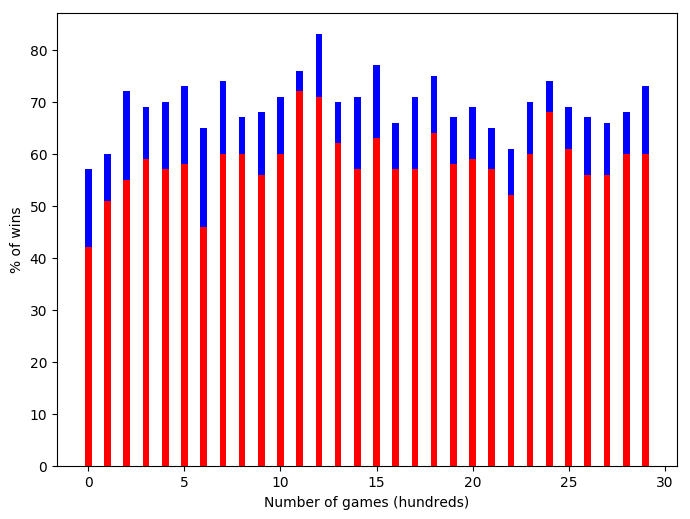

In [27]:
def draw(results):
    import numpy as np

    pos = np.arange(len(results))
    width = 0.35

    plt.figure(figsize=(8, 6), dpi=100)
    winX = [100.0*x['X']/(x['X'] + x['O'] + x[None]) for x in results]
    draw = [100.0*x[None]/(x['X'] + x['O'] + x[None]) for x in results]
    winO = [100.0*x['O']/(x['X'] + x['O'] + x[None]) for x in results]
    plt.bar(pos, winX, width, color='r')
    plt.bar(pos, draw, width, bottom=winX, color='b')
    #plt.bar(pos, winO, width)
    #plt.bar(pos+width, [100.0*x['X']/(x['X'] + x['O'] + x[None]) for x in resultsRandom], width, color='y')

    plt.ylabel('% of wins')
    plt.xlabel('Number of games (hundreds)');

draw(resultsRandom)

In [19]:
resultsRandom = resultsSmart
[x['X'] for x in resultsRandom]

[42, 51, 55, 59, 57, 58, 46, 60, 60, 56]

In [ ]:
x = resultsSmart[0]
x.get(u'X')